In [58]:
import pandas as pd
import numpy as np
import feather
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import PyNergy as pn

energy = pd.read_feather('data/energy.ftr')

sns.set_style = "seaborn-whitegrid"
sns.set_context("paper")


color = "#333"
bck_color = "#fff"
grid_color = "#ddd"

dark_mode = True
if dark_mode:
    color = "#eee"
    bck_color = "#333"
    grid_color = "#666"


charts_colors = [
    "#05B7FC",
    "#F200FA",
    "#FAA100",
    "#FAF000",
    "#0FFA00",
    "#00F5FB"
]

sns.set(
    rc={
        "axes.facecolor": bck_color,
        "grid.color": grid_color,
        "grid.linestyle": "-",
        "figure.facecolor": bck_color,
        "text.color": color,
        "xtick.color": color,
        "ytick.color": color,
        "axes.labelcolor": color,
        "axes.titlecolor": color,
        "axes.grid": True,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.right': False,
        'axes.spines.top': False,
        "axes.edgecolor": grid_color,
    }
)


In [59]:
energy.columns

Index(['code_insee_region', 'region', 'consommation', 'thermique', 'nucleaire',
       'eolien', 'solaire', 'hydraulique', 'pompage', 'bioenergies',
       'ech_physiques', 'date'],
      dtype='object')

In [60]:
energy.drop(columns=['pompage'], inplace=True)
consommation = energy[['region', 'date', 'consommation']]
consommation = consommation[ (consommation['date'].dt.year > 2012) & (consommation['date'].dt.year < 2021) ]

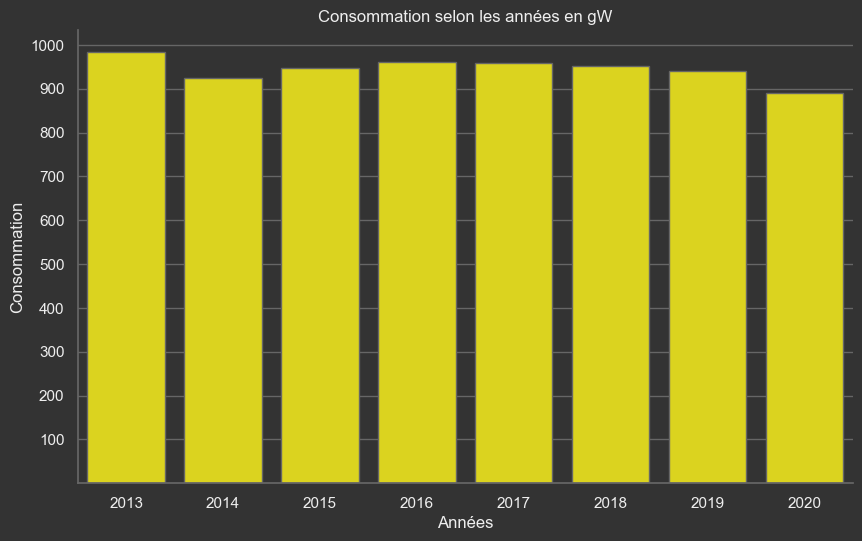

In [61]:
conso_by_year = consommation.groupby(pd.Grouper(key='date', freq='Y'))['consommation'].sum().reset_index()

conso_by_year['consommation'] = conso_by_year['consommation'] / 1000

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
g = sns.barplot(
    x=conso_by_year['date'].dt.year, 
    y='consommation', data=conso_by_year, ax=ax, 
    color=charts_colors[3], edgecolor=grid_color)

ax.set_title('Consommation selon les années en gW')
ax.set_xlabel('Années')
ax.set_ylabel('Consommation')

ax.set_yticks(np.arange(100, 1100, 100))

plt.show()

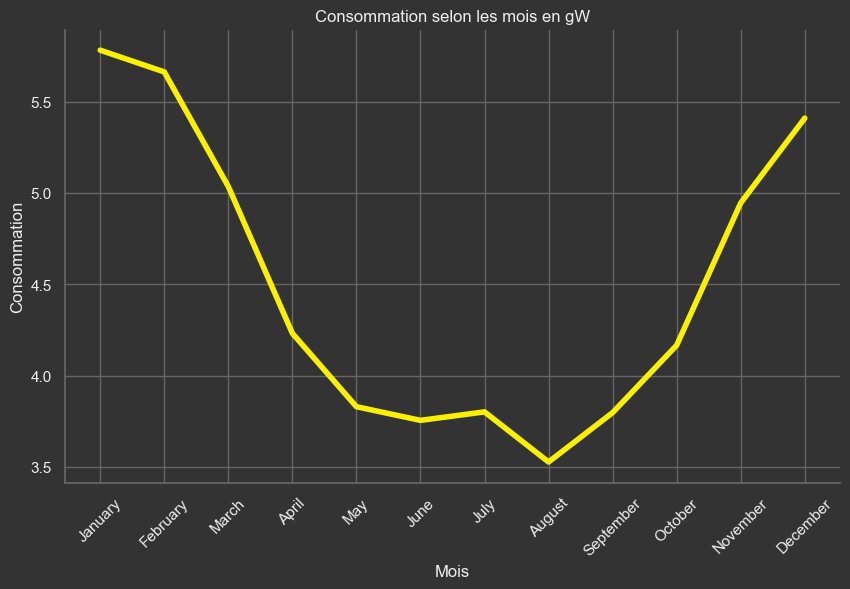

In [135]:
conso_by_month = consommation.copy()

conso_by_month['m'] = conso_by_month['date'].dt.month
conso_by_month['mn'] = conso_by_month['date'].dt.month_name()
conso_by_month = conso_by_month.groupby(['m', 'mn'])['consommation'].mean().reset_index()
conso_by_month.sort_values(by='m', ascending=True, inplace=True)

#conso_by_month['consommation'] = conso_by_month['consommation'] / 1000

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.lineplot(
    x='mn', 
    y='consommation', 
    data=conso_by_month, ax=ax,
    color=charts_colors[3], linewidth=4)

ax.set_title('Consommation selon les mois en gW')
ax.set_xlabel('Mois')
ax.set_ylabel('Consommation')

plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

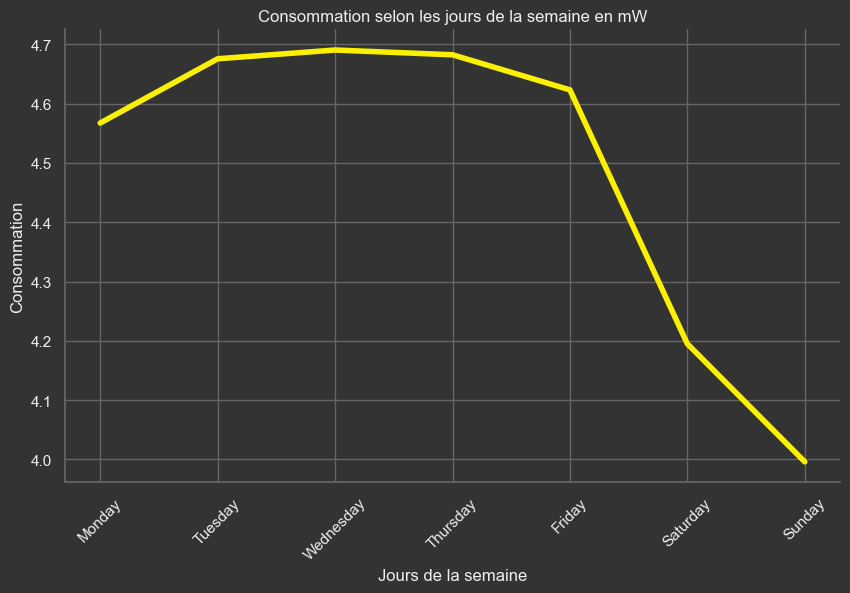

In [136]:
conso_by_dow = consommation.copy()
conso_by_dow['dow'] = conso_by_dow['date'].dt.dayofweek
conso_by_dow['dn'] = conso_by_dow['date'].dt.day_name()
conso_by_dow = conso_by_dow.groupby(['dn', 'dow'])['consommation'].mean().reset_index()
conso_by_dow.sort_values(by='dow', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

sns.lineplot(x='dn', y='consommation', data=conso_by_dow, ax=ax, linewidth=4, color=charts_colors[3])

ax.set_title('Consommation selon les jours de la semaine en mW')
ax.set_xlabel('Jours de la semaine')
ax.set_ylabel('Consommation')

plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()


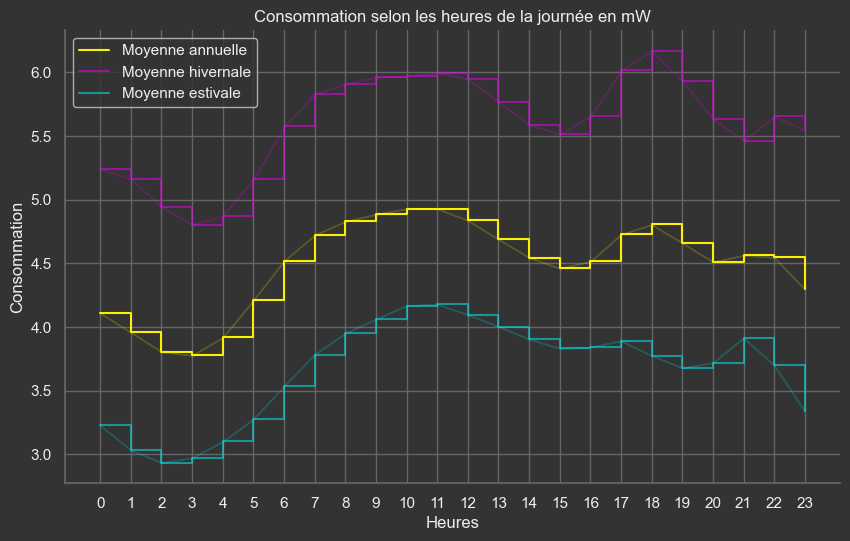

In [134]:
conso_by_hour = consommation.groupby(pd.Grouper(key='date', freq='H'))['consommation'].mean().reset_index()

month_less_conso = conso_by_hour[ conso_by_hour['date'].dt.month.isin([1, 12])].groupby(pd.Grouper(key='date', freq='H'))['consommation'].mean().reset_index()
month_most_conso = conso_by_hour[ conso_by_hour['date'].dt.month.isin([7, 8])].groupby(pd.Grouper(key='date', freq='H'))['consommation'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

sns.lineplot(
    x=conso_by_hour['date'].dt.hour, y='consommation', data=conso_by_hour, ci=False,
    ax=ax, color=charts_colors[3], drawstyle='steps-post', label='Moyenne annuelle')

sns.lineplot(
    x=month_less_conso['date'].dt.hour, y='consommation', data=month_less_conso, ci=False,
    ax=ax, color=charts_colors[1], alpha=0.5, drawstyle='steps-post', label='Moyenne hivernale')

sns.lineplot(
    x=month_most_conso['date'].dt.hour, y='consommation', data=month_most_conso, ci=False,
    ax=ax, color=charts_colors[5], alpha=0.5, drawstyle='steps-post', label='Moyenne estivale')

ax.set_title('Consommation selon les heures de la journée en mW')
ax.set_xlabel('Heures')
ax.set_ylabel('Consommation')

ax.set_xticks(np.arange(0, 24, 1))
plt.show()